<a href="https://colab.research.google.com/github/No-Qubit-Left-Behind/Control-Engineering-in-TF/blob/master/TF_GRAPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Propagator

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import scipy.signal as sp_signal
import time
print(tf.__version__)

2.2.0-rc2


In [3]:
class PropagatorVL:
    def __init__(self, input_dim, no_of_steps, delta_t):
        self.delta_t = delta_t
        self.duration = no_of_steps * delta_t
        self.no_of_steps = no_of_steps
        self.padding = 15
        """ generate a Gaussian filter array """
        self.Gaussian_filter = tf.constant(
            sp_signal.gaussian(no_of_steps + 2 * self.padding, 20),
            dtype = tf.complex128
        )
        """
            contraction_array determines the neccessity for the extra
            matrix multiplication step in the recursive method self.propagate()
            when the intermediate computation array has length not divisible
            by 2
        """
        self.contraction_array = self.gen_contraction_array(
            no_of_steps + 2 * self.padding
        )
        """
            Legendre_basis_matrix performs a transformation to a Legendre
            polynomial basis
        """
        self.Legendre_basis_matrix = self.gen_Legendre_matrix(
            input_dim, no_of_steps
        )

        self.x = tf.constant(
            [[0, 1], [1, 0]], dtype=tf.complex128
        )
        self.y = tf.constant(
            [[0 + 0j, 0 - 1j], [0 + 1j, 0 + 0j]], dtype=tf.complex128
        )
        
        """ Van Loan generators for control robustness """
        xL = -2 * np.pi *(0 + 1j) * np.block([
            [self.x.numpy(), self.x.numpy()],
            [np.zeros((2, 2)), self.x.numpy()]          
        ])
        yL = -2 * np.pi *(0 + 1j) * np.block([
            [self.y.numpy(), self.y.numpy()],
            [np.zeros((2, 2)), self.y.numpy()]          
        ])

        self.generators =  tf.stack([
                                     tf.constant(xL, dtype=tf.complex128),
                                     tf.constant(yL, dtype=tf.complex128)
                                     ])

        self.ctrl_amplitudes = tf.Variable(
            tf.zeros([input_dim, 2], dtype=tf.float64), dtype=tf.float64
        )

    @staticmethod
    def gen_contraction_array(no_of_intervals):
        if no_of_intervals > 1:
            return (
                [bool(np.mod(no_of_intervals, 2))] +
                PropagatorVL.gen_contraction_array(
                    np.floor(no_of_intervals / 2)
                )
            )
        return []

    @staticmethod
    def gen_Legendre_matrix(input_dim, output_dim):
        def Legendre_basis_vector(Legendre_coefficients):
            return np.polynomial.legendre.Legendre(
                tuple(Legendre_coefficients)
            ).linspace(output_dim)[1]
        Legendre_basis_vectors = tuple(map(
            Legendre_basis_vector, np.eye(input_dim)
        ))
        return tf.constant(
            np.column_stack(Legendre_basis_vectors), dtype = tf.float64
        )

    """
        regularize_amplitudes ensures that no individual amplitude exceeds 1
    """
    @staticmethod
    def regularize_amplitudes(amplitudes):
        amplitude_norms = tf.math.sqrt(
            tf.math.square(amplitudes[:, 0]) + tf.math.square(amplitudes[:, 1])
        )
        normalization_factor = tf.math.tanh(amplitude_norms) / amplitude_norms
        regularized_amplitudes = tf.math.multiply(
                normalization_factor[:, tf.newaxis],
                amplitudes
            )
        return regularized_amplitudes


    """ filter_amplitudes filters the frequency components of the waveform """
    @staticmethod
    def filter_amplitudes(amplitudes, filter_function_array, padding):
        padded_amplitudes = tf.pad(tf.cast(amplitudes, dtype=tf.complex128),
            tf.constant([[padding, padding], [0, 0]]), "CONSTANT"
        )
        frequency_amplitudes = tf.signal.fftshift(tf.signal.fft(
            padded_amplitudes[:, 0] + 1j * padded_amplitudes[:, 1]
        ))
        filtered_amplitudes = tf.signal.ifft(tf.signal.ifftshift(
            tf.math.multiply(filter_function_array, frequency_amplitudes)
        ))
        return tf.stack([
                         tf.math.real(filtered_amplitudes),
                         tf.math.imag(filtered_amplitudes)
                         ], axis=1)


    """
        return_physical_amplitudes transforms the input array
        self.ctrl_amplitudes into physical control amplitudes
    """    
    def return_physical_amplitudes(self):
        transformed_amplitudes = tf.linalg.matmul(
            self.Legendre_basis_matrix, self.ctrl_amplitudes
        )
        normalized_amplitudes = self.regularize_amplitudes(
            transformed_amplitudes
        )
        filtered_amplitudes = self.filter_amplitudes(
            normalized_amplitudes, self.Gaussian_filter, self.padding
        )
        return filtered_amplitudes    

    """
        exponentials() computes a vector matrix exponential after multiplying
        each self.ctrl_amplitudes row with a the vector of matrices in
        self.generators
    """
    def exponentials(self):
        physical_amplitudes = self.return_physical_amplitudes()
        exponents = tf.linalg.tensordot(
            tf.cast(physical_amplitudes, dtype=tf.complex128),
            self.delta_t * self.generators, 1
        )
        return tf.linalg.expm(exponents)
    
    """
        propagate  computes the final propagator by recursively multiplying
        each odd element in the list of matrices with each even element --
        if the length of the array is not divisible by 2 an extra computation
        step is added
    """
    def propagate(self):
        step_exps = self.exponentials()
        for is_odd in self.contraction_array:
            if is_odd:
                odd_exp = step_exps[-1, :, :]
                step_exps = tf.linalg.matmul(
                    step_exps[1::2, :, :], step_exps[0:-1:2, :, :]
                )
                step_exps = tf.concat([
                    step_exps[0:-1, :, :],
                    [tf.linalg.matmul(odd_exp, step_exps[-1, :, :])]
                ], 0)
            else:
                step_exps = tf.linalg.matmul(
                    step_exps[1::2, :, :], step_exps[0::2, :, :]
                )
        return tf.squeeze(step_exps)

    """
        target computes the final propagator fidelity squared with the
        identity operator and the norm of the robustness term
    """
    def target(self):
        propagator = self.propagate()
        tr = tf.linalg.trace(tf.linalg.matmul(self.x, propagator[0:2, 0:2]))
        """
            infidelity part in the target
        """
        infidelity = 1 - tf.math.real(tr * tf.math.conj(tr)) / (2 ** 2)
        """
            robustness term in the target
        """
        norm_squared = 1 / ((2 * np.pi * self.duration) ** 2) / 2 * (
            tf.math.real(
                tf.linalg.trace(
                    tf.linalg.matmul(
                        propagator[0:2, 2:4],
                        propagator[0:2, 2:4],
                        adjoint_b=True
                    )
                )
            )
        )
        return 0.5 * infidelity + 0.5 * norm_squared

propagatorVL = PropagatorVL(10, 300, 0.0022)

optimizer = tf.keras.optimizers.Adam(0.025)

propagatorVL.ctrl_amplitudes.assign(
    tf.random.uniform([10, 2], -1, 1, dtype=tf.float64)
)

@tf.function
def optimization_step():
    with tf.GradientTape() as tape:
        current_target = propagatorVL.target()
    gradients = tape.gradient(current_target, [propagatorVL.ctrl_amplitudes])
    optimizer.apply_gradients(zip(gradients, [propagatorVL.ctrl_amplitudes]))
    return current_target

start = time.time()

steps = range(2000)
for step in steps:
    current_target = optimization_step()
    print('step %2d: target=%2.5f' %
          (step, current_target))

end = time.time()
print(end-start)

final_pulse = propagatorVL.return_physical_amplitudes().numpy()

step  0: target=0.53556
step  1: target=0.52562
step  2: target=0.51301
step  3: target=0.49692
step  4: target=0.47744
step  5: target=0.45465
step  6: target=0.42838
step  7: target=0.39867
step  8: target=0.36603
step  9: target=0.33149
step 10: target=0.29622
step 11: target=0.26129
step 12: target=0.22750
step 13: target=0.19549
step 14: target=0.16593
step 15: target=0.13957
step 16: target=0.11717
step 17: target=0.09926
step 18: target=0.08589
step 19: target=0.07662
step 20: target=0.07069
step 21: target=0.06728
step 22: target=0.06568
step 23: target=0.06534
step 24: target=0.06583
step 25: target=0.06674
step 26: target=0.06766
step 27: target=0.06814
step 28: target=0.06788
step 29: target=0.06670
step 30: target=0.06461
step 31: target=0.06174
step 32: target=0.05831
step 33: target=0.05459
step 34: target=0.05083
step 35: target=0.04725
step 36: target=0.04400
step 37: target=0.04118
step 38: target=0.03885
step 39: target=0.03702
step 40: target=0.03563
step 41: target=

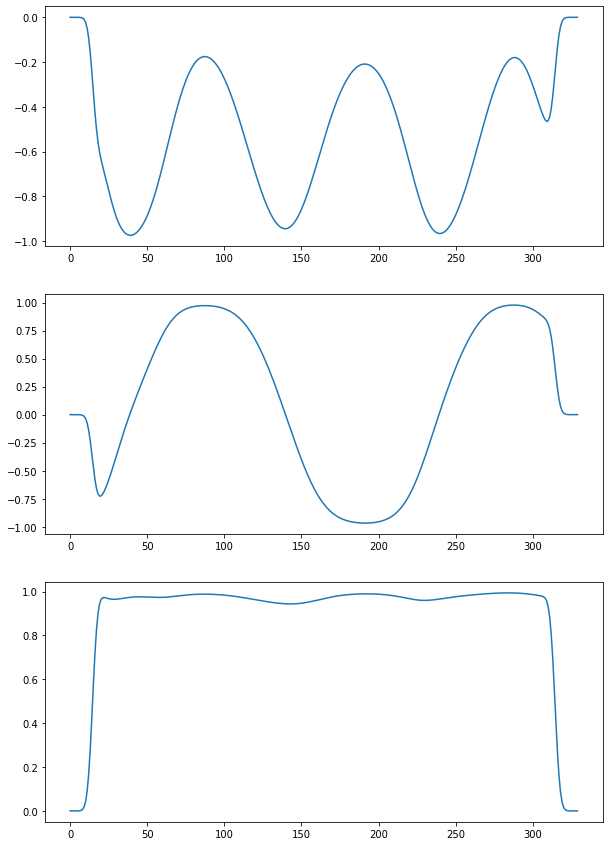

In [4]:
fig, (in_phase_fig, quadrature_fig, amplitude_fig) = plt.subplots(3, 1, figsize=(10, 15))
in_phase_fig.plot(final_pulse[:,0])
quadrature_fig.plot(final_pulse[:,1])
amplitude_fig.plot(
    np.sqrt(np.square(final_pulse[:,0]) + np.square(final_pulse[:,1]))
)

In [5]:
 np.sqrt(np.square(final_pulse[:,0]) + np.square(final_pulse[:,1]))[0]

1.3019680276713414e-08